In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npl
from scipy.sparse.linalg import cg

import pherosensor

from pheromone_dispersion.convection_diffusion_2D import DiffusionConvectionReaction2DEquation, Source
from pheromone_dispersion.diffusion_tensor import DiffusionTensor
from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.velocity import Velocity

from source_localization.cost import Cost
from source_localization.control import Control
from source_localization.adjoint_convection_diffusion_2D import AdjointDiffusionConvectionReaction2DEquation
from source_localization.obs import Obs

In [2]:
Lx = 20#50 # the length along the x-axis
Ly = 25#60 # the length along the y-axis
Delta_x = 1. # 0.4 the space step along the x-axis
Delta_y = 1. # 0.4 the space step along the y-axis
T_final = 2. # the final time of the simulation

# Test of the numerical scheme of the adjoint model

This notebook aims to test the numerical scheme of the direct model and its implementation by comparing the results of the numerical solver with a reference solution used to derive an associated source term. 

## Reference solution

In the present case, we consider a velocity field of shape $U(x,y) = (u(x,y),0)^T$ (with $u\geq0$) with the horizontal velocity $u(x,y)=\frac{4}{L_x^2}(x-L_x)^2\frac{3}{2L_y}y$.
Let us note that this velocity satisfies $u\geq0$ and $up = 0$ at $x=L_x$.

In [3]:
def velocity_horizontal(x,y):
    xx, yy = np.meshgrid(x, y)
    return 4 * (xx - Lx)**2 * 3 * yy / (Lx**2 * 2 * Ly)

def velocity_field(msh): 
    
    U_hi = np.zeros((msh.y_horizontal_interface.size, msh.x.size,2))
    U_hi[:,:,0] = velocity_horizontal(msh.x, msh.y_horizontal_interface) 
    
    U_vi = np.zeros((msh.y.size, msh.x_vertical_interface.size,2))
    U_vi[:,:,0] = velocity_horizontal(msh.x_vertical_interface, msh.y)
    
    return Velocity(msh, U_vi, U_hi)

The diffusion tensor is considered of shape $K=diag(K_x,K_y)$ with constant $K_x$ and $K_y$ and the reaction coefficient constant.

In [4]:
K_x = 5./6  # diffusion coefficient in the crosswind direction (less weak)
K_y = 0.01  # diffusion coefficient in the downwind direction (very weak)
tau_loss = 10


Hence, the 2D PDE reduces to $\partial_tp+u\partial_xp+K_x\partial_{xx}p+K_y\partial_{yy}p-\tau_{loss}p = \big(\partial_cd(c(s))\big)^*\cdot\nabla_dJ\big(s,d(c(s))\big)$\
with the final condition: $p(t=T)=0$,\
the boundary conditions:\
$K_x\partial_xp = 0$ at $x = 0$ and $x = L_x$,\
$K_y\partial_yp = 0$ at $y = 0$ and $y = L_y$,\
and $up = 0$ at $x= 0$.

We consider the reference solution $p^{ref}(x,y,t) =  (T-t)\left(cos\left(\frac{2\pi n_xx}{L_x}\right)+cos\left(\frac{2\pi n_yy}{L_y}\right)\right)$ with $n_x$ and $n_y$ two integers.\
Let us note that the boundary conditions $K_x\partial_xc = 0$ at $x = 0$ and $x = L_x$, $K_y\partial_yc = 0$ at $y = 0$ and $y = L_y$ are then satisfied. 

In [5]:
nx = 1
ny = 3
lambda_x = 2 * np.pi * nx / Lx
lambda_y = 2 * np.pi * ny / Ly

def p_reference(msh):
    xx, yy = np.meshgrid(msh.x, msh.y)
    p_ref = np.zeros((msh.t_array.size, msh.y.size, msh.x.size))

    for it,t in enumerate(msh.t_array): 
        p_ref[it,:,:] = (msh.T_final - t) * ( np.cos(lambda_x * xx) + np.cos(lambda_y * yy) )

    return p_ref



From this reference solution, we have : \
$\partial_tp^{ref}(x,y,t) = - cos\left(\frac{2\pi n_xx}{L_x}\right) - cos\left(\frac{2\pi n_yy}{L_y}\right)$\
$\partial_xp^{ref}(x,y,t)=-(T-t)\frac{2\pi n_x}{L_x}sin\left(\frac{2\pi n_xx}{L_x}\right)$, $\partial_{xx}p^{ref}(x,y,t)=-(T-t)\frac{4\pi^2 n_x^2}{L_x^2}cos\left(\frac{2\pi n_xx}{L_x}\right)$\
$\partial_yp^{ref}(x,y,t)=-(T-t)\frac{2\pi n_y}{L_y}sin\left(\frac{2\pi n_yy}{L_y}\right)$, $\partial_{yy}p^{ref}(x,y,t)=-(T-t)\frac{4\pi^2 n_y^2}{L_y^2}cos\left(\frac{2\pi n_yy}{L_y}\right)$ \
Hence, we have the associated source term: 
\begin{align*}
\Sigma=\big(\partial_cd(c(s))\big)^*\cdot\nabla_dJ\big(s,d(c(s))\big) (x,y,t) = &-\left(1+\tau_{loss}(x,y)(T-t)+K_x(T-t)\frac{4\pi^2 n_x^2}{L_x^2}\right)cos\left(\frac{2\pi n_xx}{L_x}\right)\\ 
          &- \left(1+\tau_{loss}(x,y)(T-t)+K_y(T-t)\frac{4\pi^2 n_y^2}{L_y^2}\right)cos\left(\frac{2\pi n_yy}{L_y}\right) \\
          &- u(x,y)(T-t)\frac{2\pi n_x}{L_x}sin\left(\frac{2\pi n_xx}{L_x}\right)
\end{align*}
In the present context, we assume that $\big(\partial_cd(c(s))\big)^*=\Delta tId$ and $c(s)=0$.\
Moreover, $\nabla_dJ\big(s,d\big) = 2(d-d^{obs})$. Hence, we have $\Sigma (x,y,t) = -2d^{obs}(x,y,t)$ and  
\begin{align*}
2\Delta td^{obs}(x,y,t) &= \left(1+\tau_{loss}(x,y)(T-t)+K_x(T-t)\frac{4\pi^2 n_x^2}{L_x^2}\right)cos\left(\frac{2\pi n_xx}{L_x}\right)\\ 
          &+ \left(1+\tau_{loss}(x,y)(T-t)+K_y(T-t)\frac{4\pi^2 n_y^2}{L_y^2}\right)cos\left(\frac{2\pi n_yy}{L_y}\right) \\
          &+ u(x,y)(T-t)\frac{2\pi n_x}{L_x}sin\left(\frac{2\pi n_xx}{L_x}\right)
\end{align*}

In [6]:
def Obs_reference(msh): 
    
    u = velocity_horizontal(msh.x,msh.y)
    
    N_obs = msh.y.size * msh.x.size * msh.t_array.size
    N_xy = msh.y.size * msh.x.size
    X_obs = np.zeros((N_obs,2))
    t_obs = np.zeros((N_obs,))
    C_obs = np.zeros((N_obs,))
    i_obs = 0
    
    for it, tc in enumerate(msh.t_array): 
        dt = msh.T_final - tc
        for ix, x in enumerate(msh.x): 
            for iy, y in enumerate(msh.y):
                C_obs[i_obs] = 0.5 * (1 + tau_loss * dt + K_x * lambda_x**2 * dt) * np.cos(lambda_x * x)
                C_obs[i_obs]+= 0.5 * (1 + tau_loss * dt + K_y * lambda_y**2 * dt) * np.cos(lambda_y * y)
                C_obs[i_obs]+= 0.5 * u[iy,ix] * lambda_x * dt * np.sin(lambda_x * x)
                X_obs[i_obs, 0] = x
                X_obs[i_obs, 1] = y
                t_obs[i_obs] = tc
                i_obs +=1
                
    return Obs(t_obs, X_obs, C_obs/msh.dt, msh)



## Numerical solver

The equation is solved using a semi-implicit finite volume scheme. Recall that the adjoint model is backward in time, a final condition is given.\
Let us denote $D$, $A^*$ and $R$ resp. the diffusion, adjoint of the advection and the reaction operator.\
Let us recall that 
\begin{align*}
A^*p(x,y)&= -U(x,y)\cdot\nabla p(x,y)=-\nabla\cdot(U(x,y) p(x,y))+p(x,y)\nabla\cdot U(x,y)\\ 
&=-\nabla\cdot(U(x,y) p(x,y))+p(x,y)\nabla\cdot U(x,y)1_{\nabla\cdot U>0}(x,y)+p(x,y)\nabla\cdot U(x,y)1_{\nabla\cdot U<0}(x,y)
\end{align*}
This operator is then separated in an implicit and an explicit part, resp. $A^*_ip(x,y)=p(x,y)\nabla\cdot U(x,y)1_{\nabla\cdot U<0}(x,y)$ and $A^*_ep(x,y)=-\nabla\cdot(U(x,y) p(x,y))+p(x,y)\nabla\cdot U(x,y)1_{\nabla\cdot U>0}(x,y)$.\
The time discretization is the following: $\frac{p^{n+1}-p^n}{\Delta t}-Dp^{n}+A_i^*p^n+A_e^*p^{n+1}+Rp^{n}=\Sigma^{n}$.

The space discretization of the diffusion and advection terms are presented in the notebooks dedicated to the test of the associated schemes.

In the following, $p^{solver}$ denotes the estimation of $p$ obtained by solving numerically the equation.

In [8]:
def EDP(msh, dt):
    
    U = velocity_field(msh)
    msh.calc_dt_implicit_solver(dt)
    
    K = DiffusionTensor(U, K_x, K_y)
    
    coeff_loss = tau_loss * np.ones((msh.y.size, msh.x.size))
    
    obs = Obs_reference(msh)
    
    S = Source(msh, np.zeros((msh.y.size, msh.x.size)))
    ctrl = Control(S, msh)
    cost = Cost(msh, obs, ctrl)
    cost.obs.d_est = np.zeros(cost.obs.d_obs.shape)
    return AdjointDiffusionConvectionReaction2DEquation(U, K, coeff_loss, msh, time_discretization='implicit'), cost

## Analysis of the error estimate

In this section, the estimate of the error $e(x,y,t)=|p^{solver}(x,y,t)-p^{ref}(x,y,t)|$ is analyzed.

### Analysis of the error estimate for several space step

In [9]:
coeff_dx_a = [0.5, 1., 1.5, 2.]
abs_a = np.zeros((len(coeff_dx_a)))

MAE_vs_space_step = np.zeros((len(coeff_dx_a)))
RMSE_vs_space_step = np.zeros((len(coeff_dx_a)))


for i, coeff_dx in enumerate(coeff_dx_a):
    
    msh = MeshRect2D(Lx, Ly, Delta_x * coeff_dx, Delta_y * coeff_dx, T_final)
    
    model_adjoint, cost = EDP(msh, 0.025)
    
    p_ref = p_reference(msh)
    
    abs_a[i] = msh.dx + msh.dt
    print("")
    print("dx = ", msh.dx)
    print("dt = ", msh.dt)
    
    p_solver = model_adjoint.solver(cost.obs.adjoint_derivative_obs_operator, cost) 
    p_solver = p_solver.reshape((msh.t_array.size, msh.y.size, msh.x.size))
    
    RMSE_vs_space_step[i] = npl.norm(p_solver - p_ref) / np.sqrt(p_solver.size)
    MAE_vs_space_step[i] = np.mean(np.abs(p_solver - p_ref))
    

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/pherosensor-0.1.1-py3.7.egg/pheromone_dispersion/diffusion_tensor.py:55: RuntimeWarning: invalid value encountered in true_divide
  U_at_vertical_interface = self.U.at_vertical_interface / norm_U_at_vertical_interface[:, :, None]
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/pherosensor-0.1.1-py3.7.egg/pheromone_dispersion/diffusion_tensor.py:74: RuntimeWarning: invalid value encountered in true_divide
  U_at_horizontal_interface = self.U.at_horizontal_interface / norm_U_at_horizontal_interface[:, :, None]



dx =  0.5
dt =  0.025
t = 0.000 / 2.000 s
dx =  1.0
dt =  0.025
t = 0.000 / 2.000 s
dx =  1.5
dt =  0.025
t = 0.000 / 2.000 s
dx =  2.0
dt =  0.025
t = 0.000 / 2.000 s

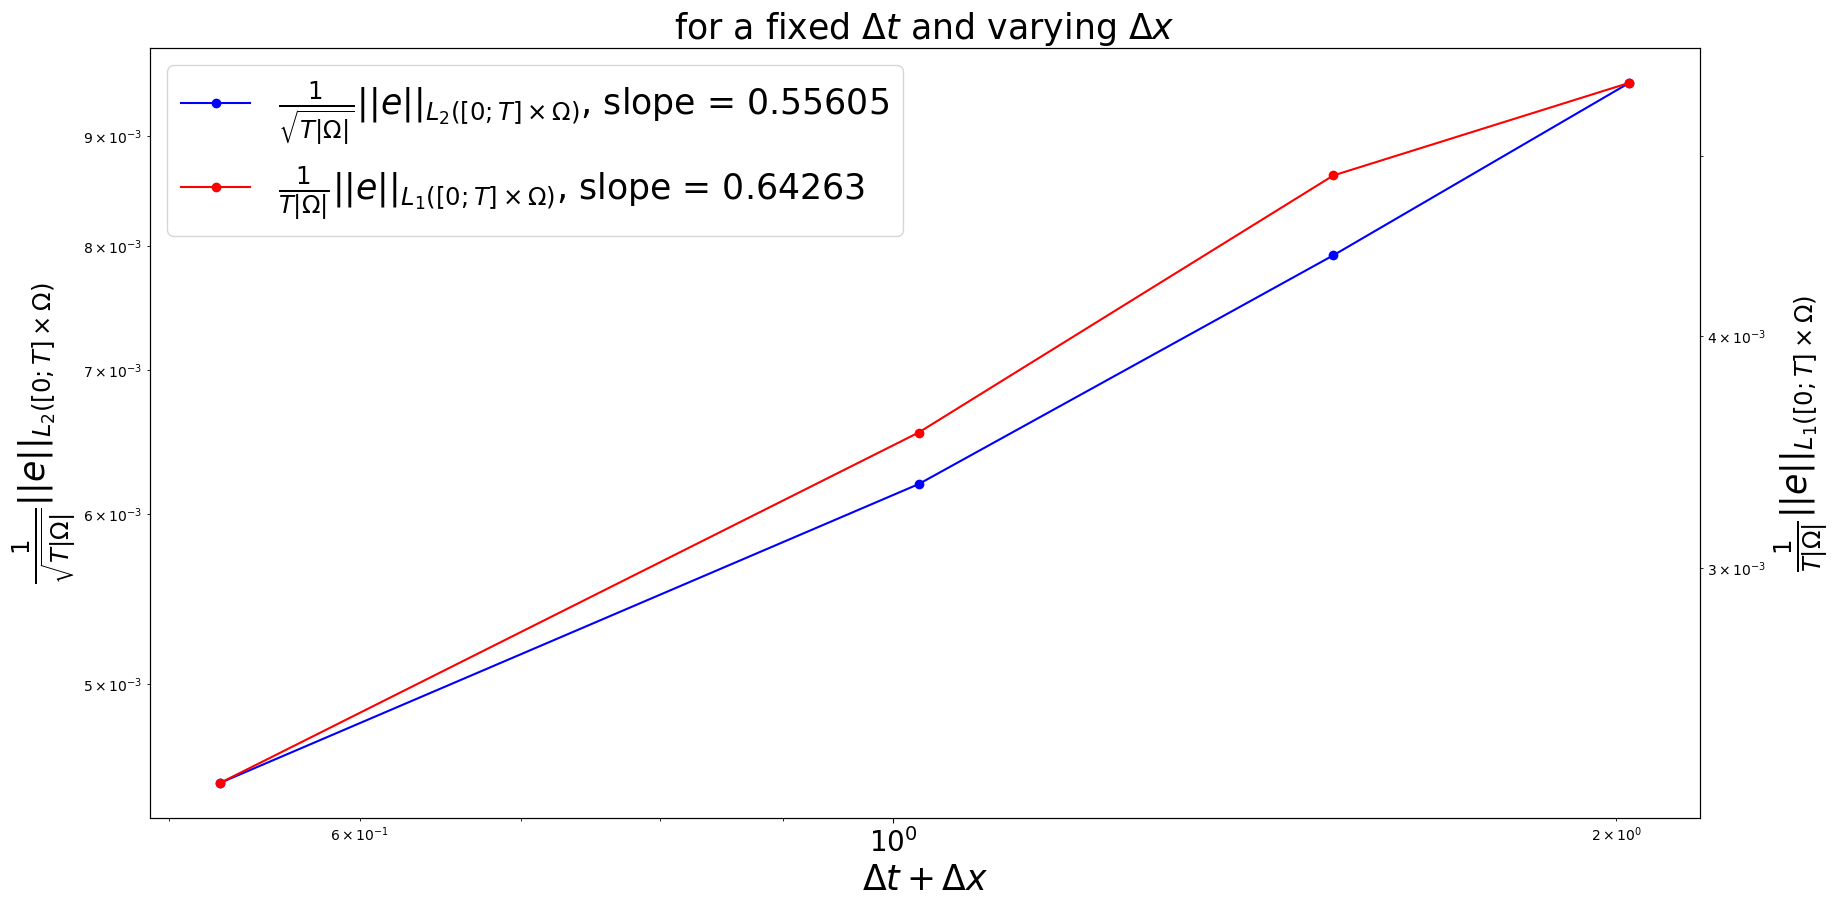

In [10]:
slope_MAE_vs_space_step = ( np.log(MAE_vs_space_step[0]) - np.log(MAE_vs_space_step[-1]) ) / ( np.log(abs_a[0]) - np.log(abs_a[-1]) ) 
slope_RMSE_vs_space_step = ( np.log(RMSE_vs_space_step[0]) - np.log(RMSE_vs_space_step[-1]) ) / ( np.log(abs_a[0]) - np.log(abs_a[-1]) ) 

fontsize = 25
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.plot(abs_a,RMSE_vs_space_step,'-ob',label=r'$\frac{1}{\sqrt{T|\Omega|}}||e||_{L_2([0;T]\times\Omega)}$'+f', slope = {"{:.5f}".format(slope_RMSE_vs_space_step)}')
ax1.tick_params(axis='both',labelsize=fontsize-5)
ax1.set_ylabel(r'$\frac{1}{\sqrt{T|\Omega|}}||e||_{L_2([0;T]\times\Omega)}$', fontsize=fontsize)
ax1.set_xlabel('$\Delta t + \Delta x$', fontsize=fontsize)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title(r'for a fixed $\Delta t$ and varying $\Delta x$', fontsize=fontsize)

ax2 = ax1.twinx()
ax2.plot(abs_a,MAE_vs_space_step,'-or',label=r'$\frac{1}{T|\Omega|}||e||_{L_1([0;T]\times\Omega)}$'+f', slope = {"{:.5f}".format(slope_MAE_vs_space_step)}')
ax2.tick_params(axis='both',labelsize=fontsize-5)
ax2.set_ylabel(r'$\frac{1}{T|\Omega|}||e||_{L_1([0;T]\times\Omega)}$', fontsize=fontsize)
ax2.set_yscale('log')

line1, label1 = ax1.get_legend_handles_labels()
line2, label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2,label1+label2,loc='upper left',prop={'size': fontsize})#, bbox_to_anchor=(1.17,1.1)